In [107]:
import sqlite3
import pandas as pd

# connect to your cleaned db
conn = sqlite3.connect("../db/seattle_airbnb.db")

query = """
SELECT 
    c.listing_id,
    c.date,
    c.available,
    c.price,
    strftime('%w', c.date) AS weekday,   -- weekday number
    strftime('%m', c.date) AS month,     -- month number
    ls.avg_sentiment,
    l.neighbourhood_cleansed,
    l.room_type,
    l.accommodates,
    l.bedrooms,
    l.bathrooms,
    l.review_scores_rating,
    l.review_scores_accuracy,
    l.review_scores_cleanliness,
    l.review_scores_checkin,
    l.review_scores_communication,
    l.review_scores_location,
    l.review_scores_value,
    l.host_is_superhost,
    l.property_type,
    l.minimum_nights,
    l.number_of_reviews,
    l.instant_bookable,
    l.latitude,
    l.longitude
FROM calendar_cleaned c
LEFT JOIN (
    SELECT listing_id, AVG(sentiment) AS avg_sentiment
    FROM reviews_cleaned
    GROUP BY listing_id
) ls
    ON c.listing_id = ls.listing_id
LEFT JOIN listings_cleaned l
    ON c.listing_id = l.id
"""

master = pd.read_sql_query(query, conn)

conn.close()

In [108]:
# quick check
print(master.shape)
master.head()

(1393570, 26)


listing_id        date  available  price weekday month  avg_sentiment  \
0      241032  2016-01-04          1   85.0       1    01       0.377606   
1      241032  2016-01-05          1   85.0       2    01       0.377606   
2      241032  2016-01-06          0    NaN       3    01       0.377606   
3      241032  2016-01-07          0    NaN       4    01       0.377606   
4      241032  2016-01-08          0    NaN       5    01       0.377606   

  neighbourhood_cleansed        room_type  accommodates  ...  \
0        West Queen Anne  Entire home/apt             4  ...   
1        West Queen Anne  Entire home/apt             4  ...   
2        West Queen Anne  Entire home/apt             4  ...   
3        West Queen Anne  Entire home/apt             4  ...   
4        West Queen Anne  Entire home/apt             4  ...   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   
1                         10.0                     9.0                 10.0   
2                         10.0                     9.0                 10.0   
3                         10.0                     9.0                 10.0   
4                         10.0                     9.0                 10.0   

   host_is_superhost  property_type  minimum_nights  number_of_reviews  \
0                  f      Apartment               1                207   
1                  f      Apartment               1                207   
2                  f      Apartment               1                207   
3                  f      Apartment               1                207   
4                  f      Apartment               1                207   

   instant_bookable   latitude   longitude  
0                 f  47.636289 -122.371025  
1                 f  47.636289 -122.371025  
2                 f  47.636289 -122.371025  
3                 f  47.636289 -122.371025  
4                 f  47.636289 -122.371025  

[5 rows x 26 columns]

In [109]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   listing_id                   1393570 non-null  int64  
 1   date                         1393570 non-null  object 
 2   available                    1393570 non-null  int64  
 3   price                        934542 non-null   float64
 4   weekday                      1393570 non-null  object 
 5   month                        1393570 non-null  object 
 6   avg_sentiment                1164715 non-null  float64
 7   neighbourhood_cleansed       1393570 non-null  object 
 8   room_type                    1393570 non-null  object 
 9   accommodates                 1393570 non-null  int64  
 10  bedrooms                     1393570 non-null  float64
 11  bathrooms                    1393570 non-null  float64
 12  review_scores_rating         1393570 non-n

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

price_by_neighbourhood = (
    master.groupby("neighbourhood_cleansed")["price"]
    .mean()
    .sort_values(ascending=False)
)
price_by_neighbourhood

neighbourhood_cleansed
Southeast Magnolia    242.077181
Portage Bay           235.960789
Westlake              229.757911
Windermere            220.630903
Briarcliff            216.080733
                         ...    
Victory Heights        79.955207
South Delridge         76.237153
Georgetown             75.851073
Rainier Beach          75.785893
Olympic Hills          70.560796
Name: price, Length: 87, dtype: float64

In [111]:
# pick top 20
top10 = price_by_neighbourhood.head(20)

# plot
plt.figure(figsize=(10,5))
sns.barplot(
    x=top10.values,
    y=top10.index,
    palette="viridis"
)
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.title("Top 10 Most Expensive Neighborhoods in Seattle (Airbnb)")
plt.show()

C:\Users\elias\AppData\Local\Temp\ipykernel_48788\2982993350.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


In [112]:
master["occupied"] = 1 - master["available"]

occupancy_pivot = master.pivot_table(
    index="weekday",
    columns="month",
    values="occupied",
    aggfunc="mean"
)
plt.figure(figsize=(10,6))
sns.heatmap(
    occupancy_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd"
)
plt.title("Occupancy Heatmap by Weekday and Month")
plt.show()

In [113]:
price_trend = (
    master.groupby("month")["price"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=price_trend,
    x="month",
    y="price",
    marker="o"
)
plt.xlabel("Month")
plt.ylabel("Average Price ($)")
plt.title("Average Airbnb Price Trend by Month in Seattle")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_48788\298918413.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_by_room.values, y=price_by_room.index, palette="magma")


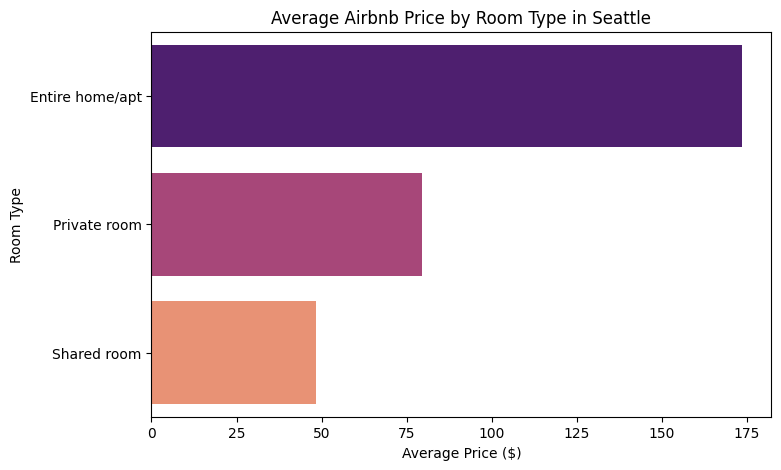

In [114]:
price_by_room = (
    master.groupby("room_type")["price"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
sns.barplot(x=price_by_room.values, y=price_by_room.index, palette="magma")
plt.xlabel("Average Price ($)")
plt.ylabel("Room Type")
plt.title("Average Airbnb Price by Room Type in Seattle")
plt.show()


In [115]:
price_by_property = (
    master.groupby("property_type")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)  # show top 10 only
)

plt.figure(figsize=(10,5))
sns.barplot(x=price_by_property.values, y=price_by_property.index, palette="coolwarm")
plt.xlabel("Average Price ($)")
plt.ylabel("Property Type")
plt.title("Top 10 Property Types by Average Airbnb Price in Seattle")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_48788\4123195379.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_by_property.values, y=price_by_property.index, palette="coolwarm")


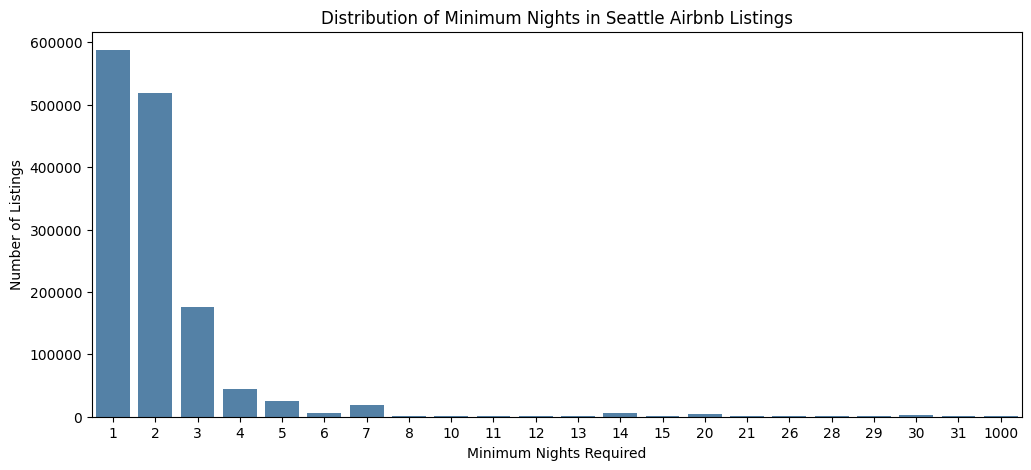

In [116]:
min_nights_counts = master["minimum_nights"].value_counts().sort_index()

plt.figure(figsize=(12,5))
sns.barplot(
    x=min_nights_counts.index,
    y=min_nights_counts.values,
    color="steelblue"
)
plt.xlabel("Minimum Nights Required")
plt.ylabel("Number of Listings")
plt.title("Distribution of Minimum Nights in Seattle Airbnb Listings")
plt.show()


BUILDING THE ML MODEL

In [117]:
features = ["accommodates",
            "bedrooms",
            "bathrooms",
            "review_scores_rating",
            "minimum_nights",
            "month"
]

X = master[features]
y = master["price"]

In [118]:
X["month"] = X["month"].astype(int)

C:\Users\elias\AppData\Local\Temp\ipykernel_48788\1415284854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["month"] = X["month"].astype(int)


In [119]:
numeric_cols = X.select_dtypes(include=["number"]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

C:\Users\elias\AppData\Local\Temp\ipykernel_48788\3790052225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())


In [120]:
# drop rows with missing price
X = X[y.notnull()]
y = y[y.notnull()]


In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [122]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [123]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")


MSE: 5308.58
R2: 0.51


ADDING FEATURES TO IMPROVE MODEL

In [124]:
master['sentiment_category'] = pd.cut(
    master['avg_sentiment'],
    bins=[-1, 0, 0.3, 0.6, 1],
    labels=['Negative', 'Neutral', 'Positive', 'Very Positive']
)
master['sentiment_category']

0          Positive
1          Positive
2          Positive
3          Positive
4          Positive
             ...   
1393565         NaN
1393566         NaN
1393567         NaN
1393568         NaN
1393569         NaN
Name: sentiment_category, Length: 1393570, dtype: category
Categories (4, object): ['Negative' < 'Neutral' < 'Positive' < 'Very Positive']

In [125]:
master['sentiment_category'] = master['sentiment_category'].astype(str).fillna('Unknown')

In [126]:
sentiment_dummies = pd.get_dummies(master['sentiment_category'], prefix="sentiment")
master = pd.concat([master, sentiment_dummies], axis=1)
sentiment_dummies

sentiment_Negative  sentiment_Neutral  sentiment_Positive  \
0                     False              False                True   
1                     False              False                True   
2                     False              False                True   
3                     False              False                True   
4                     False              False                True   
...                     ...                ...                 ...   
1393565               False              False               False   
1393566               False              False               False   
1393567               False              False               False   
1393568               False              False               False   
1393569               False              False               False   

         sentiment_Very Positive  sentiment_nan  
0                          False          False  
1                          False          False  
2                          False          False  
3                          False          False  
4                          False          False  
...                          ...            ...  
1393565                    False           True  
1393566                    False           True  
1393567                    False           True  
1393568                    False           True  
1393569                    False           True  

[1393570 rows x 5 columns]

In [127]:
master['is_weekend'] = master['weekday'].isin(['5', '6']).astype(int)


In [128]:
import numpy as np
master['price_per_guest'] = master['price'] / master['accommodates'].replace(0, np.nan)


In [129]:
master['price_per_guest'] = master['price_per_guest'].fillna(master['price_per_guest'].median())

In [130]:
room_type_dummies = pd.get_dummies(master['room_type'], prefix='room')
room_type_dummies

room_Entire home/apt  room_Private room  room_Shared room
0                        True              False             False
1                        True              False             False
2                        True              False             False
3                        True              False             False
4                        True              False             False
...                       ...                ...               ...
1393565                  True              False             False
1393566                  True              False             False
1393567                  True              False             False
1393568                  True              False             False
1393569                  True              False             False

[1393570 rows x 3 columns]

In [131]:
master = pd.concat([master, room_type_dummies], axis=1)

In [132]:
neigh_dummies = pd.get_dummies(master['neighbourhood_cleansed'], prefix='neigh')

In [133]:
master = pd.concat([master, neigh_dummies], axis=1)

In [134]:
room_type_dummies = room_type_dummies.astype(int)
neigh_dummies = neigh_dummies.astype(int)
sentiment_dummies = sentiment_dummies.astype(int)

In [151]:
base_features = [
    "accommodates",
    "bedrooms",
    "bathrooms",
    "review_scores_rating",
    "minimum_nights",
    "month",
    "is_weekend"
]

final_features = (
    base_features
    + list(room_type_dummies.columns)
    + list(neigh_dummies.columns)
    + list(sentiment_dummies.columns)
)



In [158]:
X = master[final_features]
y = master["price"]


In [159]:
numeric_cols = X.select_dtypes(include=["number"]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

X = X[y.notnull()]
y = y[y.notnull()]

C:\Users\elias\AppData\Local\Temp\ipykernel_48788\3916963857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())


In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [162]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [163]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MSE: 4108.58
RMSE: 64.10
R2: 0.62


LET US USE RANDOM FOREST

In [164]:
if 'price_per_guest' in final_features:
    final_features.remove('price_per_guest')

In [165]:
from sklearn.ensemble import RandomForestRegressor

In [166]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [167]:
y_pred_rf = rf_model.predict(X_test)

In [168]:
from sklearn.metrics import mean_squared_error, r2_score

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2: {r2_rf:.2f}")

Random Forest MSE: 1005.40
Random Forest RMSE: 31.71
Random Forest R2: 0.91


In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color="steelblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Random Forest: Actual vs. Predicted Airbnb Prices")
plt.show()


In [170]:
master.to_csv("../data/processed/master_final.csv", index=False)

In [172]:
import joblib
joblib.dump(rf_model, "../models/random_forest_airbnb.pkl")

['../models/random_forest_airbnb.pkl']